<a href="https://colab.research.google.com/github/FatimaHabib/Sentiment-Analysis/blob/main/Sentiment_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and Import Dependincies

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# transforems contains the NLP model (bert-base-multilingual-uncased-sentiment), it allows to performe the sentiment analysis task
# 
!pip install transformers requests beautifulsoup4 pandas numpy



In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests # make a request to the website we want to scrap
from bs4 import BeautifulSoup # webscrapping, extract the data from the requested webpage
import re 

# 2. Instantiate Model

In [5]:
# load the model and the tokenizer 
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')



# 3.Encode and Calculate Sentiment


In [8]:
# tokenize the sentence and convert the tokens into list of numbers, that will be used as inputs to BERT model
# BERT expect the sentence to start with [CLS] (encoded into 101) and ended by [SEP] (encoded into 102)

sent_1 = "It was good but couldve been better. Great"
sent_2 = "BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. "

#encoding the sentences, the tokenizer return a list of lists (encoded sentences) 
tokens_sent1 = tokenizer.encode( sent_1, return_tensors='pt')
tokens_sent2 = tokenizer.encode( sent_2, return_tensors='pt')


In [9]:
tokens_sent1

tensor([[  101, 10197, 10140, 12050, 10502, 12296, 10598, 10662, 16197,   119,
         11838,   102]])

In [10]:
tokens_sent2

tensor([[  101, 40668, 10127, 32610, 10125, 10110, 11460, 84789, 10107, 45261,
         49361,   117, 13136,   122, 10107, 10110,   121, 10107, 10114, 91884,
         10986, 10103, 10536, 45261, 10107,   119,   102]])

In [13]:
# decode the tokens list to get the original sentence
tokenizer.decode(tokens_sent1[0])

'[CLS] it was good but couldve been better. great [SEP]'

In [15]:
# performe sentiment analysis
sentiment1 = model(tokens_sent1)

In [16]:
sentiment1

SequenceClassifierOutput(loss=None, logits=tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [18]:
# predict the sentiment, the higher the number the better the sentiment
# the answer is 4 that means it is a good review 
int(torch.argmax(sentiment1.logits) + 1 )

4

# 4. Extract Data

In [19]:
#get the text out of the webpage
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont') 
# pass the page to a beautifulsoup object
soup = BeautifulSoup(r.text, 'html.parser')
#using regex to find any class that contains 'comment' in its name
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex}) # p(tag)
reviews = [result.text for result in results]

In [27]:
print("The number of extracted reviews is {}".format(len(reviews)))

The number of extracted reviews is 11


In [ ]:
r.text

In [22]:
results[1]

<p class="comment__09f24__gu0rG css-qgunke"><span class=" raw__09f24__T4Ezm" lang="en">It was ok. The coffee wasn't the best but it was fine. The relish on the breakfast roll was yum which did make it sing. So perhaps I just got a bad coffee but the food was good on my visit.</span></p>

In [23]:
# get the text
results[1].text

"It was ok. The coffee wasn't the best but it was fine. The relish on the breakfast roll was yum which did make it sing. So perhaps I just got a bad coffee but the food was good on my visit."

# 5. Load Reviews in DataFrame and Score 

In [30]:
import numpy as np
import pandas as pd

In [33]:
df = pd.DataFrame(np.array(reviews), columns = ['review'])

In [37]:
df["review"].iloc[0]

'Great staff and food. \xa0Must try is the pan fried Gnocchi! \xa0The staff were really friendly and the coffee was good as well'

In [38]:
# create a function that reuturn the sentiment score from a given setence  (using the pretrained model)
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [40]:
sentiment_score(df["review"].iloc[0]) 

5

In [43]:
# apply sentiment_score function to all the reviews in the dataset 
# the input sequence is limited to 512 tokens
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [44]:
df


,review,sentiment
0,Great staff and food. Must try is the pan fri...,5
1,It was ok. The coffee wasn't the best but it w...,3
2,I came to Social brew cafe for brunch while ex...,5
3,Ricotta hot cakes! These were so yummy. I ate ...,5
4,I went here a little while ago- a beautiful mo...,2
5,We came for brunch twice in our week-long visi...,4
6,Ron & Jo are on the go down under and Wow! We...,5
7,Great coffee and vibe. That's all you need. C...,5
8,Great coffee and vibe. That's all you need. C...,4
9,Good coffee and toasts. Straight up and down -...,5


In [46]:
df.describe()

,sentiment
count,11.000000
mean,4.181818
std,1.078720
min,2.000000
25%,3.500000
50%,5.000000
75%,5.000000
max,5.000000


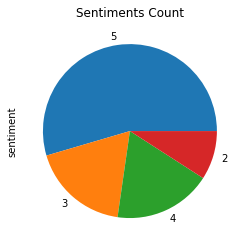

In [59]:
import matplotlib.pyplot as plt
df = df.sort_values(['sentiment'])
df['sentiment'].value_counts().plot(kind='pie') 
plt.title('Sentiments Count')
plt.show()


From the pie chart above, we conclude that most of the reviews hold positive sentiment, the customer would tend to buy this product.